<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_Compare_ElegantRL_RLlib_Stablebaseline3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinRL: Compare ElegantRL, RLlib, and Stablebaselines3

## Part 1: Getting Started - Install Python Packages 

 ### 1.1 Install DRL libraries: FinRL, ElegantRL, RLlib

In [1]:
## install elegantrl library
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
## install rllib/ray library
!pip install ray[default]
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-j4wqix0q
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-j4wqix0q
     |████████████████████████████████| 90.8 MB 235 bytes/s 
     |████████████████████████████████| 448 kB 24.1 MB/s 
  Created wheel for elegantrl: filename=elegantrl-0.3.2-py3-none-any.whl size=130535 sha256=0a54b86e33ed14aa3cbf8308fa035a909b5b8b61bf87d9dfe54e2a20a1a761c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6s3uyg5p/wheels/52/9a/b3/08c8a0b5be22a65da0132538c05e7e961b1253c90d6845e0c6
Successfully built elegantrl
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 119 kB 52.1 MB/s 
     |████████████████████████████████| 201 kB 46.1 MB/s 
     |████████████████████████████████| 82 kB 177 kB/s 
     |████████████████████████████████| 1.1 MB 44.0 MB/s 
     |████████████████████████████████| 128 kB 66.3 MB/s 
     |█████████████████████

### 1.2 Check if the additional packages needed are present, if not install them

In [4]:
!pip install trading_calendars
!pip install alpaca_trade_api
!pip install ccxt
!pip install jqdatasdk
!pip install wrds

!pip install lz4
!pip install ray[tune]
!pip install tensorboardX
!pip install gputil


To run the code below, you need several more step.
If you run this notebook on colab, you have three steps to do:

1.  go to /usr/local/lib/python3.7/dist-packages/elegantrl/agents and upload the project_ddpg.py to this folder.
2.   then open model.py in /usr/local/lib/python3.7/dist-packages/finrl/drl_agents/elegantrl add several lines:

> *   from elegantrl.agents.project_ddpg import project_DDPG
> *   add "project_ddpg":project_DDPG in MODELS
> *   add "project_ddpg" in OFF_POLICY_MODELS

3.   Save all and restart the kernal

After finishing steps above, you can continue running cells below. You don't need to do those steps again if you relink to the colab.









### 1.3 Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime

from elegantrl.agents import *
#from elegantrl.run import *
import torch 
import ray
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
#from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent as DRLAgent_sb3
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.drl_agents.elegantrl.models import DRLAgent as DRLAgent_erl

from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline



/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Part 2: Train & Test Function

### 2.1 Train

In [2]:
def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, model_name, if_vix = True,
          **kwargs):
    
    #fetch data
    print("fech data")
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    print("finish fetch data")
    env_config = {'price_array':price_array,
              'tech_array':tech_array,
              'turbulence_array':turbulence_array,
              'if_train':True}
    env_instance = env(config=env_config)

    #read parameters
    cwd = kwargs.get('cwd','./'+str(model_name))

    if drl_lib == 'elegantrl':
        break_step = kwargs.get('break_step', 1e6)
        erl_params = kwargs.get('erl_params')

        agent = DRLAgent_erl(env = env,
                             price_array = price_array,
                             tech_array=tech_array,
                             turbulence_array=turbulence_array)
        
        model = agent.get_model(model_name, model_kwargs = erl_params)
        trained_model = agent.train_model(model=model, 
                                          cwd=cwd,
                                          total_timesteps=break_step)
      
    elif drl_lib == 'rllib':
        total_episodes = kwargs.get('total_episodes', 100)
        rllib_params = kwargs.get('rllib_params')

        agent_rllib = DRLAgent_rllib(env = env,
                       price_array=price_array,
                       tech_array=tech_array,
                       turbulence_array=turbulence_array)

        model,model_config = agent_rllib.get_model(model_name)

        model_config['lr'] = rllib_params['lr']
        model_config['train_batch_size'] = rllib_params['train_batch_size']
        model_config['gamma'] = rllib_params['gamma']

        #ray.shutdown()
        trained_model = agent_rllib.train_model(model=model, 
                                          model_name=model_name,
                                          model_config=model_config,
                                          total_episodes=total_episodes)
        trained_model.save(cwd)
        
            
    elif drl_lib == 'stable_baselines3':
        total_timesteps = kwargs.get('total_timesteps', 1e6)
        agent_params = kwargs.get('agent_params')

        agent = DRLAgent_sb3(env = env_instance)

        model = agent.get_model(model_name, model_kwargs = agent_params)
        trained_model = agent.train_model(model=model, 
                                tb_log_name=model_name,
                                total_timesteps=total_timesteps)
        print('Training finished!')
        trained_model.save(cwd)
        print('Trained model saved in ' + str(cwd))
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')


### 2.2 Test

In [3]:
def test(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, model_name, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)

    #load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(model_name))
    print("price_array: ",len(price_array))

    if drl_lib == 'elegantrl':
        episode_total_assets = DRLAgent_erl.DRL_prediction(model_name=model_name,
                                            cwd=cwd,
                                            net_dimension=net_dimension,
                                            environment=env_instance)

        return episode_total_assets
    
    elif drl_lib == 'rllib':
        #load agent
        episode_total_assets = DRLAgent_rllib.DRL_prediction(
                                  model_name=model_name, 
                                  env = env,
                                  price_array=price_array,
                                  tech_array=tech_array,
                                  turbulence_array=turbulence_array,
                                  agent_path = cwd)

        return episode_total_assets


    elif drl_lib == 'stable_baselines3':
        episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
                                  model_name=model_name, 
                                  environment = env_instance,
                                  cwd = cwd)
        
        return episode_total_assets
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

## Part 3: Set DRL Environment

### 3.1 Get the stock trading env from neo_finrl

In [9]:
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [4]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 5.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh


### 3.2 Set some basic parameters

In [5]:
env = StockTradingEnv

In [6]:
TRAIN_START_DATE = '2016-01-01'
TRAIN_END_DATE = '2020-07-30'

TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-12-17'
TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

## Part 4: Compare the three agents

### 4.1 eRL

In [7]:
ERL_PARAMS = {"learning_rate": 3e-5,"batch_size": 2048,"gamma":  0.985,
        "seed":312,"net_dimension":512, "target_step":5000, "eval_gap":60}

#### Train

In [8]:
#demo for elegantrl
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      model_name='project_ddpg', 
      cwd='./test_project_ddpg',
      erl_params=ERL_PARAMS,
      break_step=1e5
      )

fech data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

#### Test

In [9]:
account_value_erl_project_ddpg=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = config.DOW_30_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        model_name='project_ddpg', 
                        cwd='./test_project_ddpg', 
                        net_dimension = 512)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.7/dist-packages/finrl/drl_agents/elegantrl/models.py:124: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  s_tensor = _torch.as_tensor((state,), device=device)


Test Finished!
episode_return 1.3329098693989334


In [10]:
len(account_value_erl_project_ddpg)

349

#### Plot

In [18]:
TEST_END_DATE

'2021-12-17'

In [11]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (348, 9)
Annual return          0.240255
Cumulative returns     0.346276
Annual volatility      0.138174
Sharpe ratio           1.632453
Calmar ratio           2.690189
Stability              0.891742
Max drawdown          -0.089308
Omega ratio            1.316869
Sortino ratio          2.384128
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031226
Daily value at risk   -0.016513
dtype: float64


In [13]:
account_value_erl_proj_ddpg = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl_project_ddpg[0:len(account_value_erl_project_ddpg)-1]})

In [14]:
account_value_erl_proj_ddpg.tail()

,date,account_value
343,2021-12-10,1.348221e+06
344,2021-12-13,1.334653e+06
345,2021-12-14,1.325448e+06
346,2021-12-15,1.340249e+06
347,2021-12-16,1.332910e+06


In [15]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=account_value_erl_proj_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.231326
Cumulative returns     0.332910
Annual volatility      0.137647
Sharpe ratio           1.585496
Calmar ratio           2.359107
Stability              0.935306
Max drawdown          -0.098056
Omega ratio            1.310459
Sortino ratio          2.315254
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.991659
Daily value at risk   -0.016476
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (347, 8)


Start date,2020-08-03
End date,2021-12-16
Total months,16
,Backtest
Annual return,23.133%
Cumulative returns,33.291%
Annual volatility,13.765%
Sharpe ratio,1.59
Calmar ratio,2.36
Stability,0.94
Max drawdown,-9.806%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.81,2020-09-02,2020-10-30,2021-01-07,92
1,4.95,2021-11-16,2021-12-01,NaT,NaN
2,4.81,2021-02-17,2021-03-04,2021-03-12,18
3,4.30,2021-08-16,2021-09-30,2021-10-15,45
4,3.48,2021-05-07,2021-06-18,2021-06-30,39


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


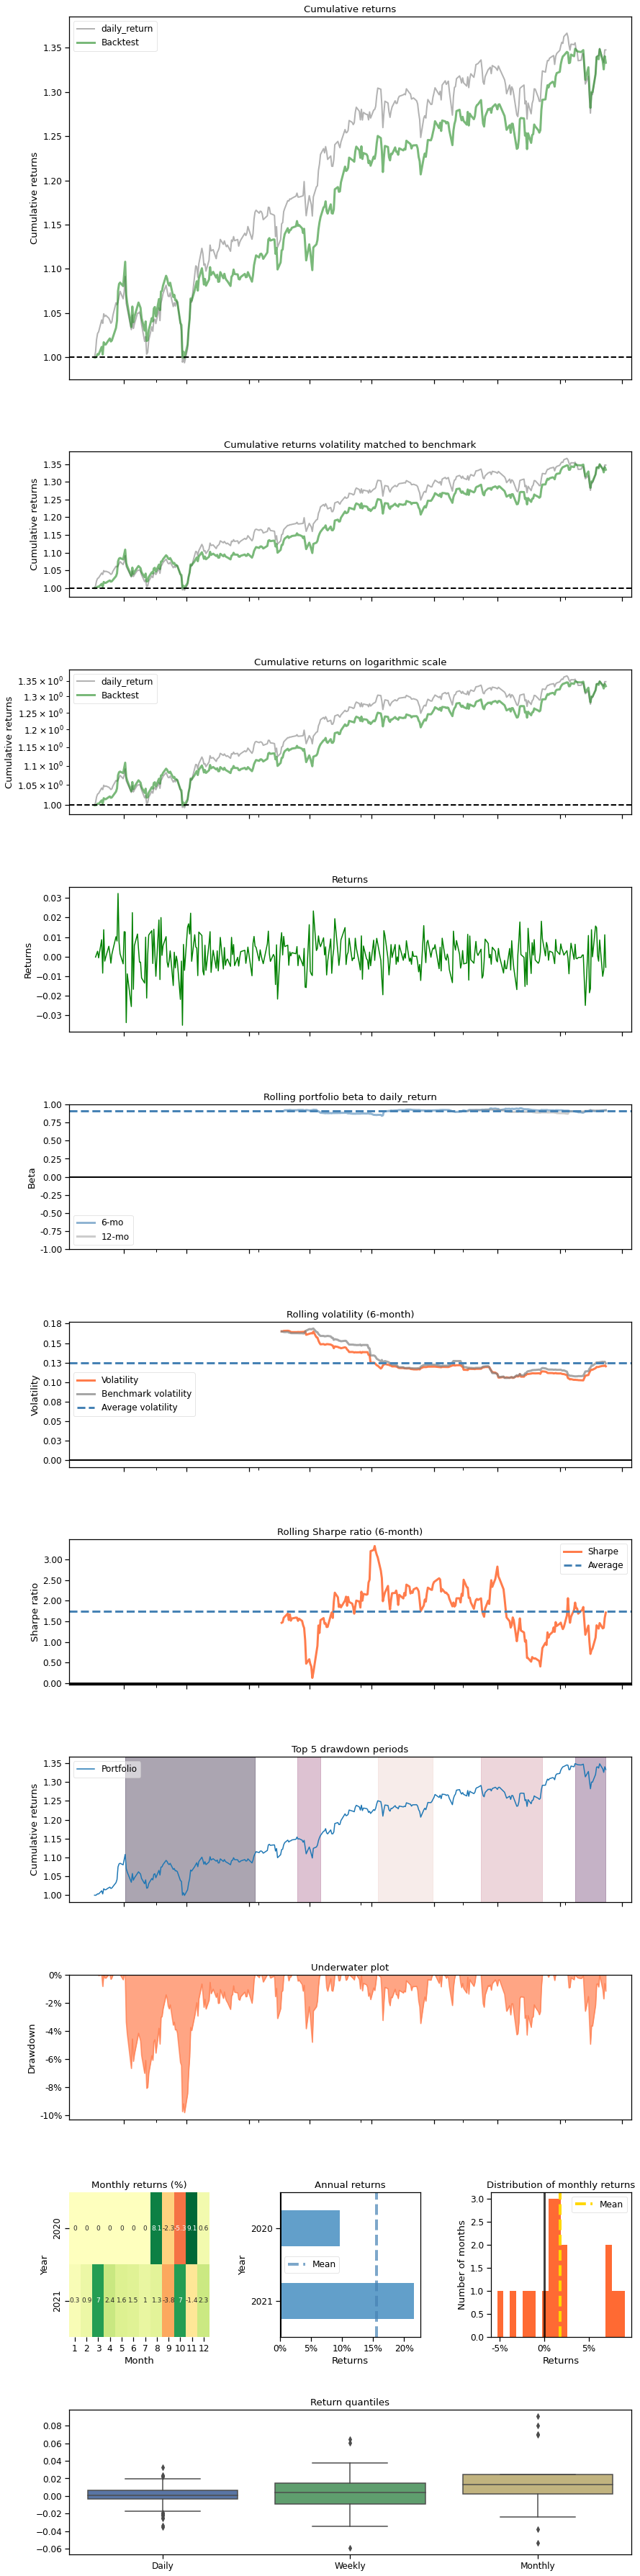

In [16]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl_proj_ddpg, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl_proj_ddpg.loc[0,'date'],
             baseline_end = account_value_erl_proj_ddpg.loc[len(account_value_erl_proj_ddpg)-1,'date'])

elegentrl ddpg:

In [18]:
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      model_name='ddpg', 
      cwd='./test_ele_ddpg',
      erl_params=ERL_PARAMS,
      break_step=1e5
      )

fech data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

test:

In [19]:
account_value_erl_ddpg=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = config.DOW_30_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        model_name='ddpg', 
                        cwd='./test_ele_ddpg', 
                        net_dimension = 512)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [20]:
len(account_value_erl_ddpg)

349

plot:

In [21]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (348, 9)
Annual return          0.240255
Cumulative returns     0.346276
Annual volatility      0.138174
Sharpe ratio           1.632453
Calmar ratio           2.690189
Stability              0.891742
Max drawdown          -0.089308
Omega ratio            1.316869
Sortino ratio          2.384128
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031226
Daily value at risk   -0.016513
dtype: float64


In [22]:
account_value_erl_ddpg = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl_ddpg[0:len(account_value_erl_ddpg)-1]})
account_value_erl_ddpg.tail()

,date,account_value
343,2021-12-10,1.386866e+06
344,2021-12-13,1.377351e+06
345,2021-12-14,1.366806e+06
346,2021-12-15,1.385176e+06
347,2021-12-16,1.374125e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (347, 8)


Start date,2020-08-03
End date,2021-12-16
Total months,16
,Backtest
Annual return,25.878%
Cumulative returns,37.413%
Annual volatility,13.548%
Sharpe ratio,1.77
Calmar ratio,2.97
Stability,0.95
Max drawdown,-8.722%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.72,2020-09-02,2020-10-30,2020-11-16,54
1,4.82,2021-02-17,2021-03-04,2021-03-15,19
2,4.77,2021-09-03,2021-09-30,2021-10-15,31
3,4.68,2021-11-08,2021-12-01,2021-12-10,25
4,3.01,2021-05-07,2021-05-12,2021-06-04,21


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


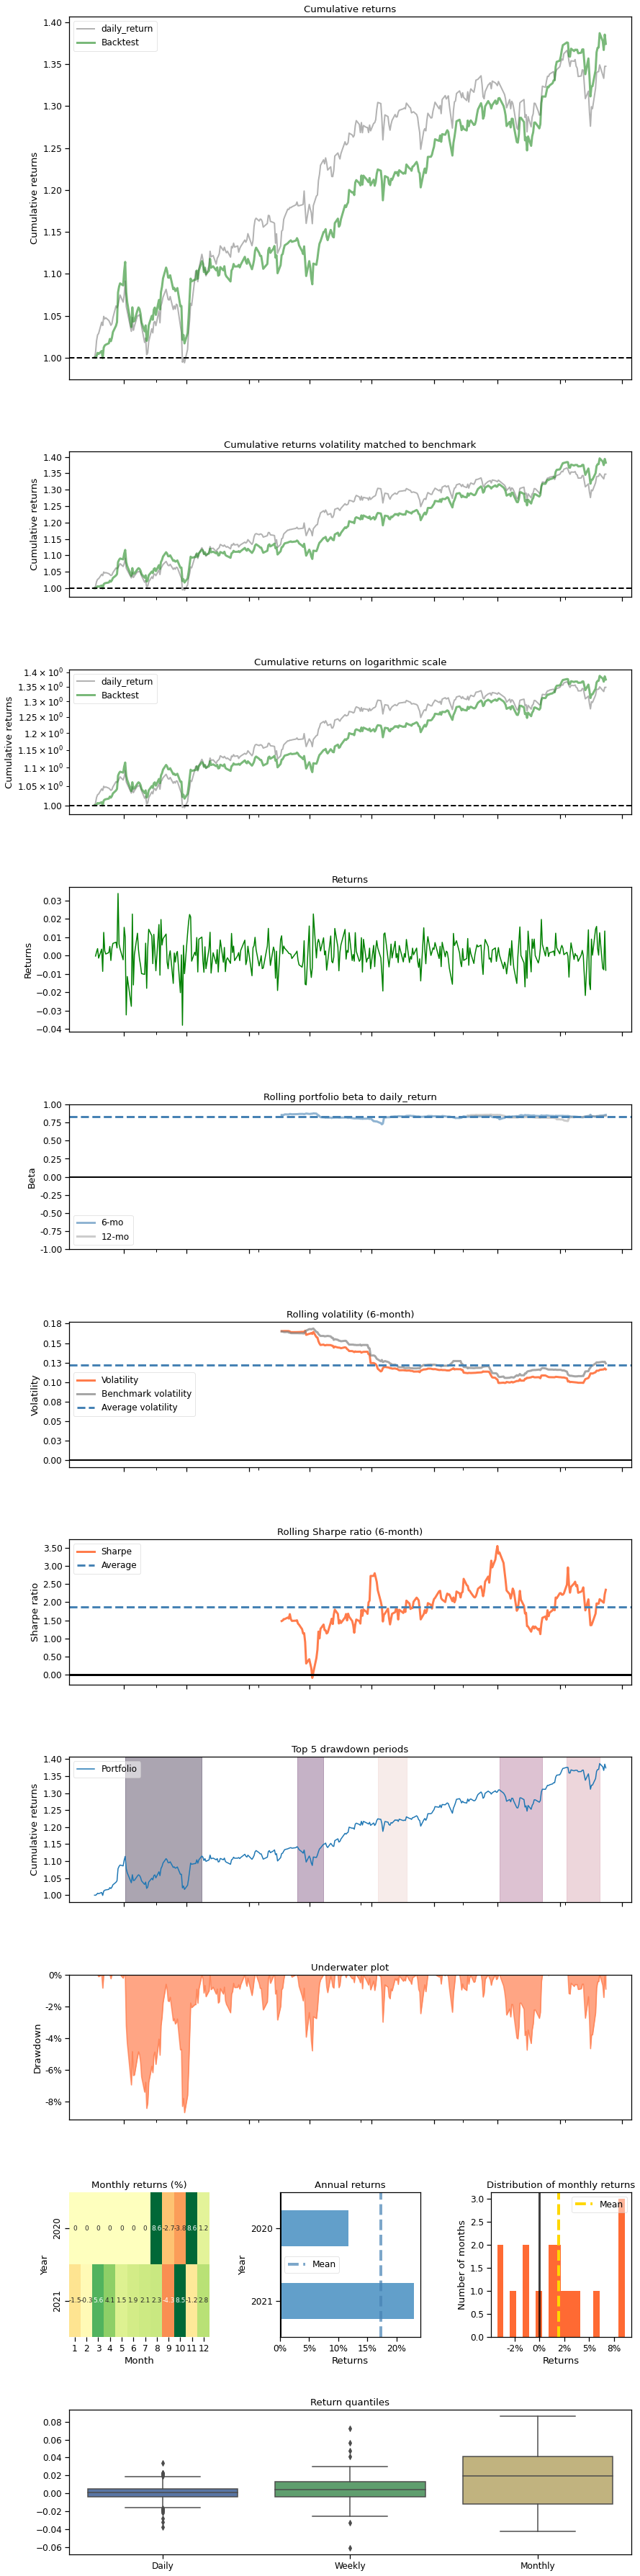

In [23]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl_ddpg, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl_ddpg.loc[0,'date'],
             baseline_end = account_value_erl_ddpg.loc[len(account_value_erl_ddpg)-1,'date'])

4.1.3 A2C in elegantrl

Train

In [34]:
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      model_name='a2c', 
      cwd='./test_a2c',
      erl_params=ERL_PARAMS,
      break_step=1e5
      )

fech data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

Test

In [35]:
account_value_erl_a2c=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = config.DOW_30_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        model_name='a2c', 
                        cwd='./test_a2c', 
                        net_dimension = 512)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Plot

In [36]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (348, 9)
Annual return          0.240255
Cumulative returns     0.346276
Annual volatility      0.138174
Sharpe ratio           1.632453
Calmar ratio           2.690189
Stability              0.891742
Max drawdown          -0.089308
Omega ratio            1.316869
Sortino ratio          2.384128
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031226
Daily value at risk   -0.016513
dtype: float64


In [37]:
account_value_erl_a2c = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl_a2c[0:len(account_value_erl_a2c)-1]})
account_value_erl_a2c.tail()

,date,account_value
343,2021-12-10,1.097833e+06
344,2021-12-13,1.092765e+06
345,2021-12-14,1.098972e+06
346,2021-12-15,1.104109e+06
347,2021-12-16,1.108624e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (347, 8)


Start date,2020-08-03
End date,2021-12-16
Total months,16
,Backtest
Annual return,7.753%
Cumulative returns,10.862%
Annual volatility,10.21%
Sharpe ratio,0.78
Calmar ratio,0.76
Stability,0.75
Max drawdown,-10.152%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.15,2021-08-16,2021-12-01,NaT,NaN
1,6.15,2021-06-04,2021-06-18,2021-08-10,48
2,3.97,2021-02-17,2021-02-26,2021-03-10,16
3,3.77,2021-05-10,2021-05-12,2021-06-03,19
4,2.43,2021-01-06,2021-02-01,2021-02-05,23


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


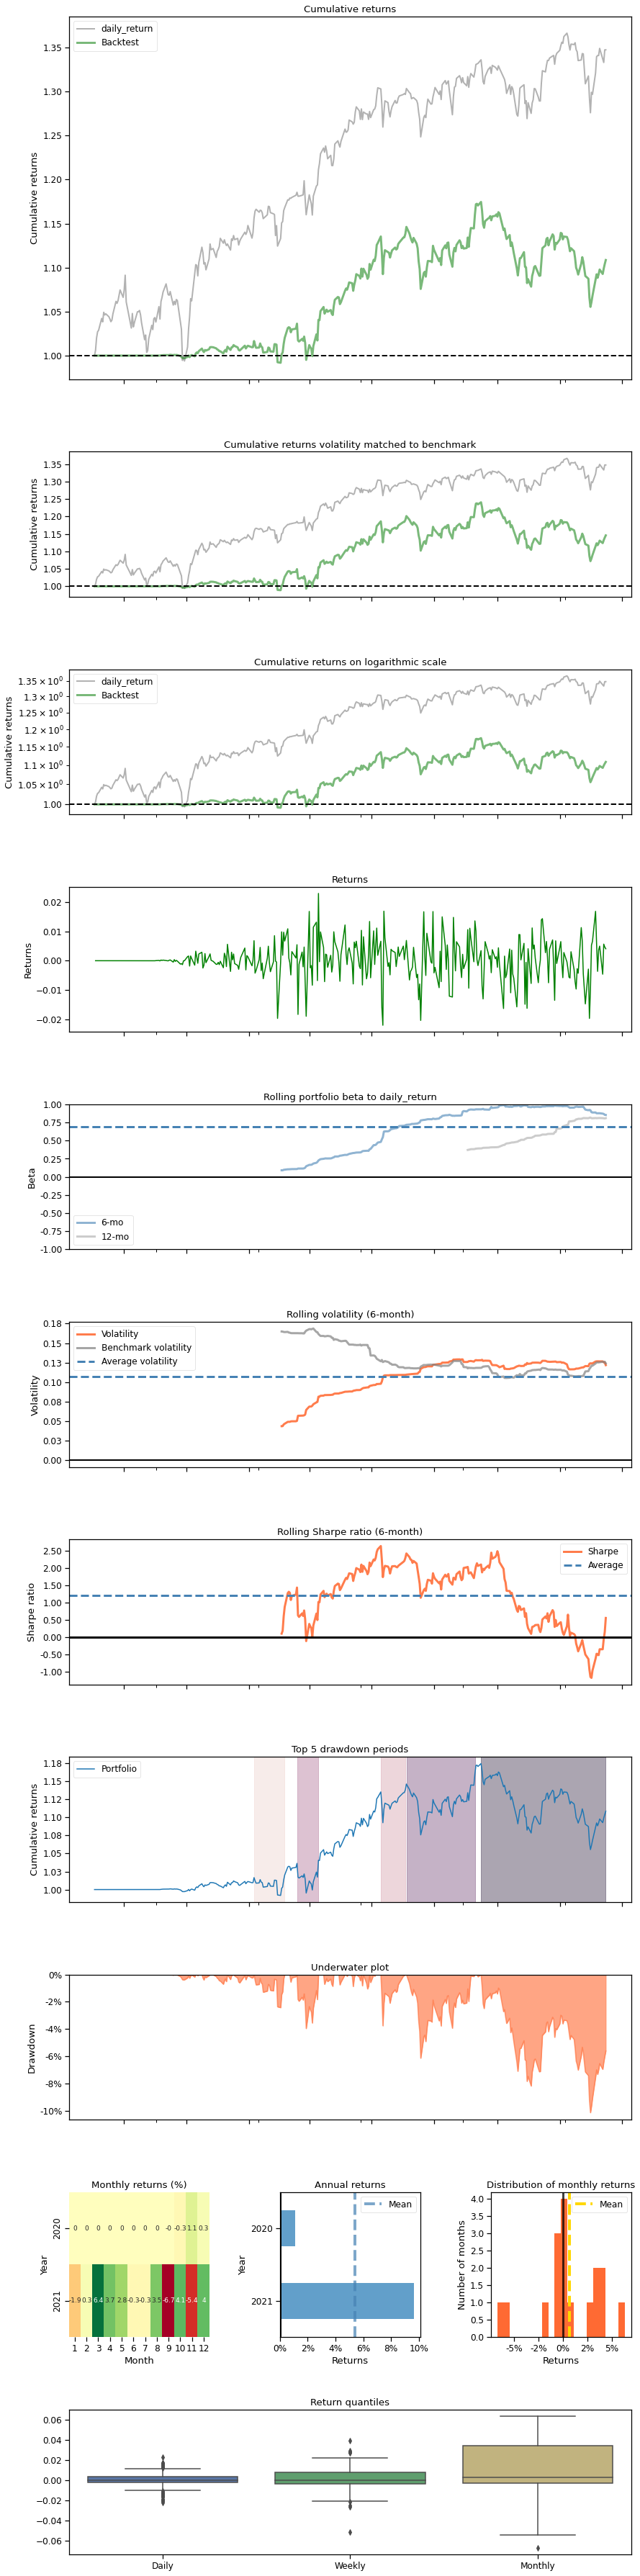

In [38]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl_a2c, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl_a2c.loc[0,'date'],
             baseline_end = account_value_erl_a2c.loc[len(account_value_erl_a2c)-1,'date'])

### 4.2 RLlib

In [24]:
RLlib_PARAMS = {"lr": 5e-6,"train_batch_size": 800,"gamma": 0.99}

#### Train

In [25]:
#demo for rllib
ray.shutdown() #always shutdown previous session if any

train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='rllib', 
      env=env, 
      model_name='ddpg', 
      cwd='./test_rllib_ddpg',
      rllib_params = RLlib_PARAMS,
      total_episodes=25)

fech data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

2021-12-21 01:47:31,293	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-21 01:47:36,031	INFO trainer.py:723 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also want to then set `eager_tracing=True` in order to reach similar execution speed as with static-graph mode.
2021-12-21 01:47:36,037	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-12-21 01:47:36,746	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


#### Test

In [27]:
ray.shutdown() #always shutdown previous session if any

account_value_rllib = test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
     drl_lib='rllib', 
     env=env, 
     model_name='ddpg', 
     cwd='./test_rllib_ddpg/checkpoint_000025/checkpoint-25',
     rllib_params = RLlib_PARAMS)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-12-21 03:51:07,989	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-21 03:51:10,108	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: ./test_rllib_ddpg/checkpoint_000025/checkpoint-25
2021-12-21 03:51:10,113	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': 0, '_time_total': 6845.482099533081, '_episodes_total': 22}


Restoring from checkpoint path ./test_rllib_ddpg/checkpoint_000025/checkpoint-25
episode return: 1.32077714650729
Test Finished!


In [28]:
len(account_value_rllib)

349

#### Plot

In [29]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (348, 9)
Annual return          0.240255
Cumulative returns     0.346276
Annual volatility      0.138174
Sharpe ratio           1.632453
Calmar ratio           2.690189
Stability              0.891742
Max drawdown          -0.089308
Omega ratio            1.316869
Sortino ratio          2.384128
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031226
Daily value at risk   -0.016513
dtype: float64


In [30]:
len(baseline_df.date)

348

In [31]:
account_value_rllib = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_rllib[0:len(account_value_rllib)-1]})

In [32]:
perf_stats_all = backtest_stats(account_value=account_value_rllib)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.223199
Cumulative returns     0.320777
Annual volatility      0.168829
Sharpe ratio           1.281417
Calmar ratio           2.082976
Stability              0.857139
Max drawdown          -0.107154
Omega ratio            1.246212
Sortino ratio          1.905637
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.261664
Daily value at risk   -0.020412
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (347, 8)


Start date,2020-08-03
End date,2021-12-16
Total months,16
,Backtest
Annual return,22.32%
Cumulative returns,32.078%
Annual volatility,16.883%
Sharpe ratio,1.28
Calmar ratio,2.08
Stability,0.86
Max drawdown,-10.715%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.72,2020-09-02,2020-10-30,2020-11-16,54
1,7.49,2021-11-15,2021-12-01,NaT,NaN
2,5.51,2021-08-12,2021-09-21,2021-10-20,50
3,5.33,2021-02-24,2021-03-04,2021-03-12,13
4,4.99,2021-06-04,2021-07-19,2021-08-10,48


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


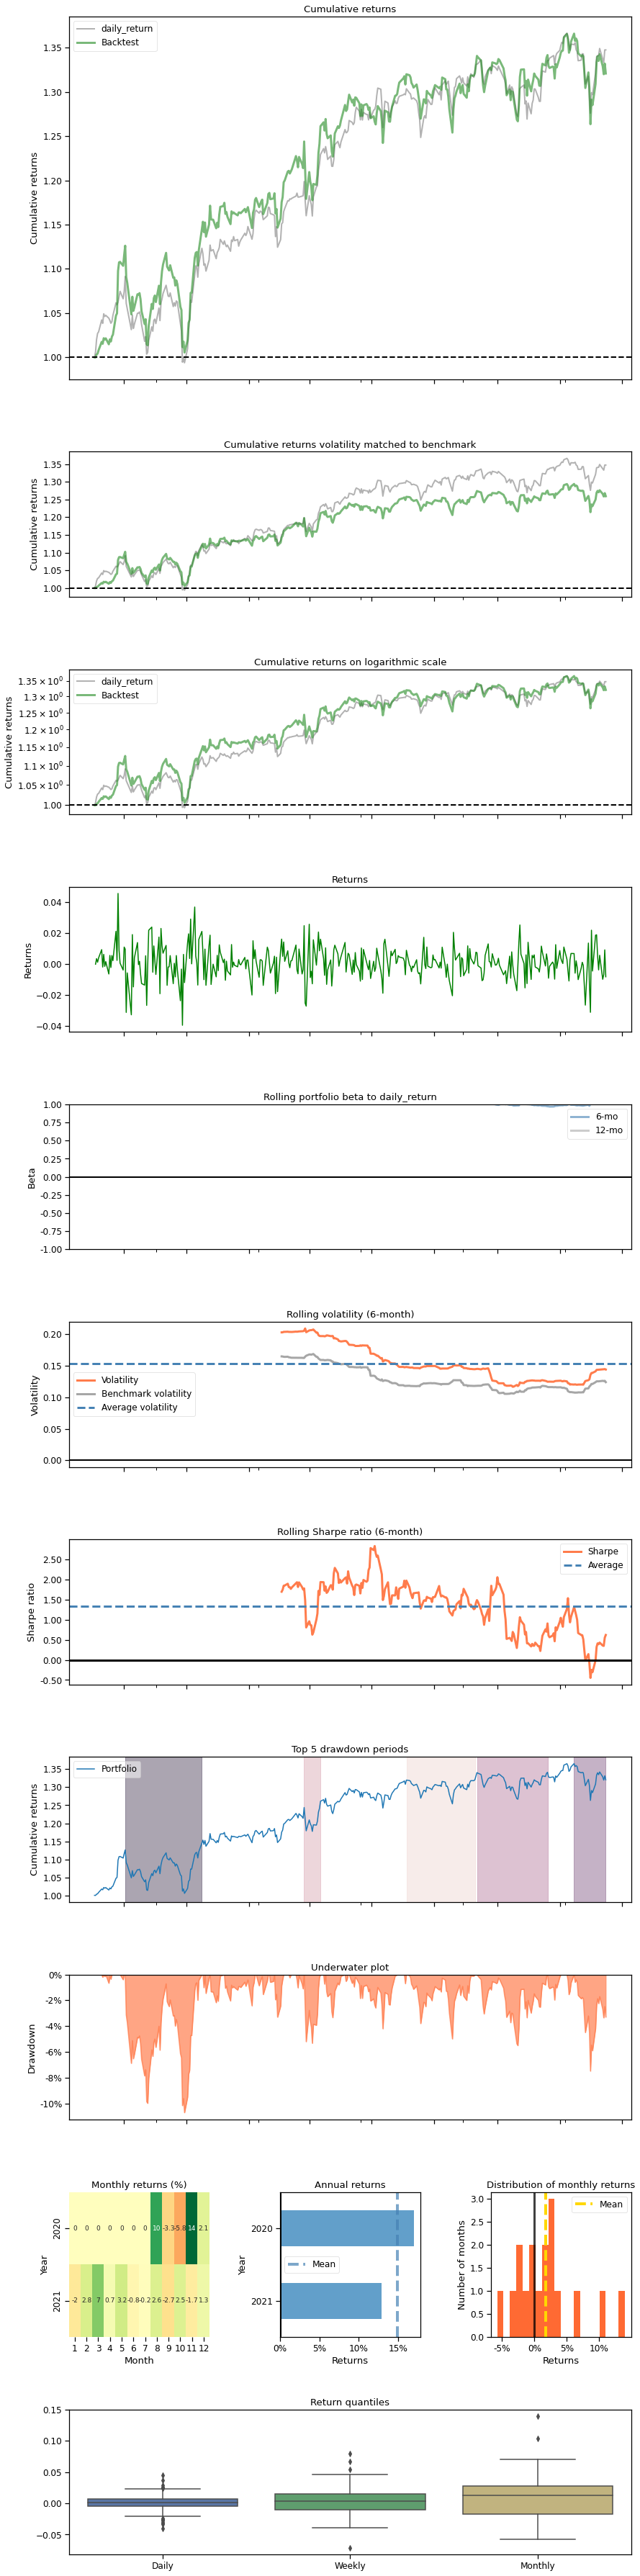

In [33]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_rllib, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_rllib.loc[0,'date'],
             baseline_end = account_value_rllib.loc[len(account_value_rllib)-1,'date'])

### 4.3 Stable-baselines3

In [39]:
#SAC_PARAMS = {"batch_size": 128,"buffer_size": 100000,"learning_rate": 0.0001,"learning_starts": 100,"ent_coef": "auto_0.1",}
#PPO_PARAMS = {"n_steps": 2048,"ent_coef": 0.01,"learning_rate": 0.00025,"batch_size": 128}
#TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
#A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 3e-5}

#### Train

In [40]:
#demo for stable-baselines3
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='stable_baselines3', 
      env=env, 
      model_name='ddpg', 
      cwd='./test_stb3_ddpg',
      agent_params = DDPG_PARAMS,
      total_timesteps=1e4)


fech data
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

#### Test

In [41]:
account_value_sb3=test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST, 
     drl_lib='stable_baselines3', 
     env=env, 
     model_name='ddpg', 
     cwd='./test_stb3_ddpg.zip')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [42]:
len(account_value_sb3)

349

#### Plot

In [43]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (348, 9)
Annual return          0.240255
Cumulative returns     0.346276
Annual volatility      0.138174
Sharpe ratio           1.632453
Calmar ratio           2.690189
Stability              0.891742
Max drawdown          -0.089308
Omega ratio            1.316869
Sortino ratio          2.384128
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.031226
Daily value at risk   -0.016513
dtype: float64


In [44]:
account_value_sb3 = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_sb3[0:len(account_value_sb3)-1]})

In [45]:
perf_stats_all = backtest_stats(account_value=account_value_sb3)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.257631
Cumulative returns     0.372392
Annual volatility      0.158512
Sharpe ratio           1.529937
Calmar ratio           2.782713
Stability              0.816772
Max drawdown          -0.092583
Omega ratio            1.291289
Sortino ratio          2.317857
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.106091
Daily value at risk   -0.019008
dtype: float64


In [46]:
account_value_sb3.tail()

,date,account_value
343,2021-12-10,1.375281e+06
344,2021-12-13,1.356749e+06
345,2021-12-14,1.358145e+06
346,2021-12-15,1.365559e+06
347,2021-12-16,1.372392e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (347, 8)


Start date,2020-08-03
End date,2021-12-16
Total months,16
,Backtest
Annual return,25.763%
Cumulative returns,37.239%
Annual volatility,15.851%
Sharpe ratio,1.53
Calmar ratio,2.78
Stability,0.82
Max drawdown,-9.258%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.26,2020-09-02,2020-10-28,2020-11-10,50
1,7.98,2021-08-12,2021-12-01,NaT,NaN
2,5.74,2021-06-04,2021-06-18,2021-08-10,48
3,4.80,2021-01-12,2021-01-29,2021-02-05,19
4,3.75,2021-03-17,2021-03-24,2021-04-16,23


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


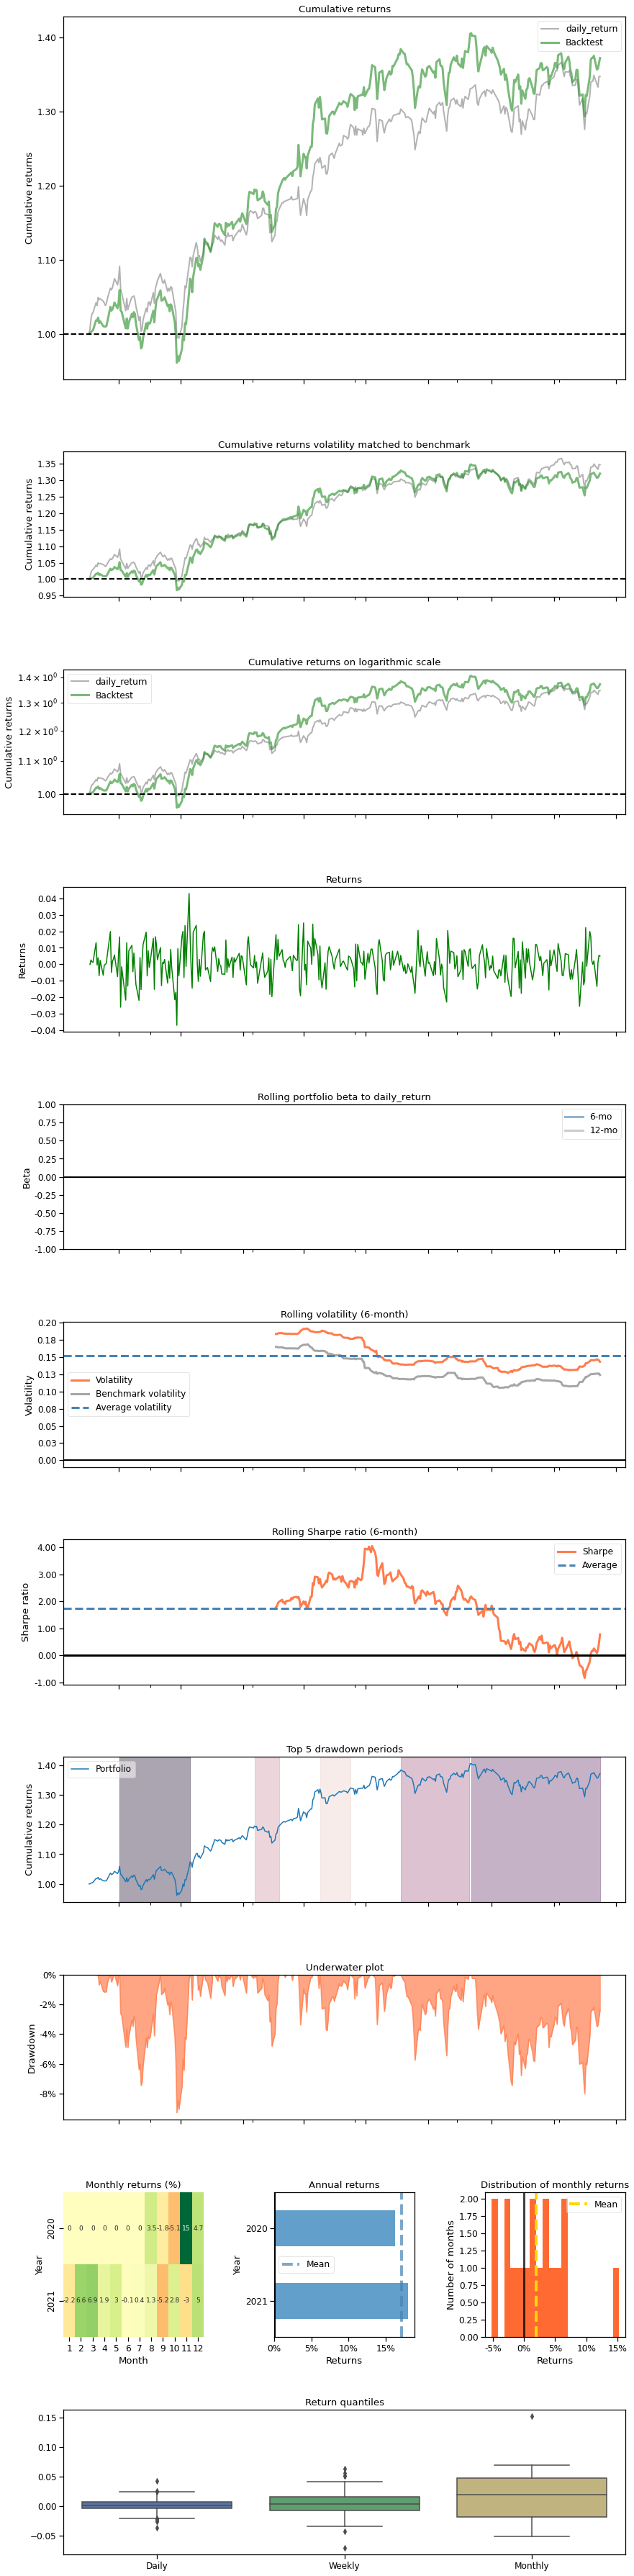

In [47]:
print("==============Compare to DJIA===========")
#%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])

## Part 5: Use Plotly to compare eRL, RLlib and SB3

In [48]:
baseline_df

,date,open,high,low,close,adjcp,volume,tic,day
0,2020-08-03,26542.320312,26707.259766,26534.380859,26664.400391,26664.400391,439380000,^DJI,0
1,2020-08-04,26664.609375,26832.720703,26597.820312,26828.470703,26828.470703,346350000,^DJI,1
2,2020-08-05,26924.779297,27221.669922,26924.779297,27201.519531,27201.519531,366000000,^DJI,2
3,2020-08-06,27170.820312,27394.099609,27145.250000,27386.980469,27386.980469,322460000,^DJI,3
4,2020-08-07,27321.679688,27456.240234,27223.550781,27433.480469,27433.480469,321170000,^DJI,4
...,...,...,...,...,...,...,...,...,...
343,2021-12-10,35830.550781,35982.691406,35710.429688,35970.988281,35970.988281,361200000,^DJI,4
344,2021-12-13,35958.929688,35958.929688,35609.531250,35650.949219,35650.949219,441110000,^DJI,0
345,2021-12-14,35605.730469,35779.468750,35441.738281,35544.179688,35544.179688,440900000,^DJI,1
346,2021-12-15,35549.351562,35943.839844,35389.300781,35927.429688,35927.429688,424720000,^DJI,2


In [49]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [50]:
daily_return = account_value_sb3.copy()
daily_return['sb3_ddpg_return'] = account_value_sb3.account_value.pct_change()
daily_return['erl_ddpg_return'] = account_value_erl_ddpg.account_value.pct_change()
daily_return['erl_a2c_return'] = account_value_erl_a2c.account_value.pct_change()
daily_return['project_ddpg_return'] = account_value_erl_proj_ddpg.account_value.pct_change()
daily_return['rllib_ddpg_return'] = account_value_rllib.account_value.pct_change()
daily_return['djia_return'] = baseline_df.adjcp.pct_change()


In [51]:
daily_return.head()

,date,account_value,sb3_ddpg_return,erl_ddpg_return,erl_a2c_return,project_ddpg_return,rllib_ddpg_return,djia_return
0,2020-08-03,1.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-04,9.998269e+05,-0.000173,-0.000223,0.0,-0.000240,-0.000204,0.006153
2,2020-08-05,1.002474e+06,0.002647,0.002071,0.0,0.001241,0.003416,0.013905
3,2020-08-06,1.003960e+06,0.001483,0.003852,0.0,0.002750,0.001056,0.006818
4,2020-08-07,1.005150e+06,0.001184,-0.001340,0.0,-0.000636,0.003898,0.001698


In [52]:
daily_return.to_csv('daily_return_erl_sb3_rllib.csv',index=False)
#daily_return = pd.read_csv('daily_return_erl_sb3_rllib.csv')

In [53]:
rllib_cumpod =(daily_return.rllib_ddpg_return+1).cumprod()-1
sb3_cumpod =(daily_return.sb3_ddpg_return+1).cumprod()-1
erl_cumpod =(daily_return.erl_ddpg_return+1).cumprod()-1
a2c_cumpod =(daily_return.erl_a2c_return+1).cumprod()-1
project_ddpg_cumpod =(daily_return.project_ddpg_return+1).cumprod()-1
dji_cumpod =(daily_return.djia_return+1).cumprod()-1

In [54]:
time_ind = pd.Series(daily_return.date)

In [55]:
trace0_portfolio = go.Scatter(x = time_ind, y = rllib_cumpod, mode = 'lines', name = 'RLlib')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = sb3_cumpod, mode = 'lines', name = 'Stablebaselines3')
trace3_portfolio = go.Scatter(x = time_ind, y = erl_cumpod, mode = 'lines', name = 'ElegantRL')
trace4_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C-ElegantRL')
trace5_portfolio = go.Scatter(x = time_ind, y = project_ddpg_cumpod, mode = 'lines', name = 'project-DDPG')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [56]:
fig = go.Figure()
fig.add_trace(trace5_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace2_portfolio)

fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)




fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *70}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()